In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

from scipy import stats as sstats
import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline
pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
pl.rcParams['xtick.labelsize'] = 7
pl.rcParams['ytick.labelsize'] = 7
pl.rcParams['axes.labelsize'] = 7

# needs to find the library of functions
sys.path.append('../../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'selectivity'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
folder = './autorestore/preprocessing/'
for var in ('time_ax', 'events', 'cycles',
            'CYCLE_START', 'ANALYSIS_WINDOW',
            'US_START', 'US_DURATION',
            'is_rewardt', 'is_shockt',
            'is_coyotet', 'is_femalet',
            'is_consumed', 'consumption_times',
            'consumptions', 'is_blastt', 
            'licks', 'mean_image', 'contours'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [6]:
print CYCLE_START

-6


In [7]:
from scipy import stats as sstats

In [8]:
def update_selectivity(selectivity, trial_types, between_what, and_what, append='', append_trial='t'):

    for t in trial_types:

        # this one selects which trials to consider
        which_cycles = eval('is_%s'%(t+append_trial))
        print sum(which_cycles),
            
        if not np.any(which_cycles):
            continue
        
        selectivity[t+append] = ut.compute_selectivity(time_ax, events, cycles[which_cycles],
                                                       between_what, and_what)

In [9]:
# CHOOSE WHAT PERIOD DEFINES THE CS WITH REF. TO CYCLE START
baseline_timeframe = (US_START-CYCLE_START-ANALYSIS_WINDOW, US_START-CYCLE_START)
us_timeframe = (US_START-CYCLE_START, US_START+ANALYSIS_WINDOW-CYCLE_START)
us_late_timeframe = (US_START+ANALYSIS_WINDOW-CYCLE_START, US_START+US_DURATION-CYCLE_START+ANALYSIS_WINDOW)
pre_timeframe = (US_START-CYCLE_START-ANALYSIS_WINDOW-ANALYSIS_WINDOW, US_START-CYCLE_START-ANALYSIS_WINDOW)
fourSec_baseline_timeframe= (US_START-CYCLE_START-4, US_START-CYCLE_START)
fourSec_us_timeframe = (US_START-CYCLE_START, US_START+4-CYCLE_START)
#fourSec_pre_timeframe = (US_START-CYCLE_START-8, US_START-CYCLE_START-4)

#create selectivity where activity window starts at first lick after reward delivery
times = consumption_times[is_consumed]
us_timeframe_consumption = np.c_[us_timeframe[0]+times, us_timeframe[0]+times+ANALYSIS_WINDOW]
bs_timeframe_consumption = np.c_[us_timeframe[0]+times-ANALYSIS_WINDOW-0.5, us_timeframe[0]+times-0.5]
pre_timeframe_consumption = np.c_[us_timeframe[0]+times-ANALYSIS_WINDOW-ANALYSIS_WINDOW-0.5, us_timeframe[0]+times-ANALYSIS_WINDOW-0.5]
fourSec_us_timeframe_consumption = np.c_[us_timeframe[0]+times, us_timeframe[0]+times+4]
fourSec_bs_timeframe_consumption = np.c_[us_timeframe[0]+times-4.5, us_timeframe[0]+times-0.5]

In [10]:
selectivity = {}

trial_types = np.r_[['shock', 'reward', 'coyote', 'female', 'blast']]
# will eventually eliminate 'shock' and 'reward',
#but keeping for now to make sure they mostly match shock_10 and consumption values for 2018 collective

# US
update_selectivity(selectivity, trial_types, us_timeframe, baseline_timeframe, '_us')
# US late
#update_selectivity(selectivity, trial_types, us_late_timeframe, baseline_timeframe, '_late')
#pre-baseline
update_selectivity(selectivity, trial_types, pre_timeframe, baseline_timeframe, '_pre')
# 4s_US
update_selectivity(selectivity, trial_types, fourSec_us_timeframe, fourSec_baseline_timeframe, '_4s_us')
# 4s_pre-baseline
#update_selectivity(selectivity, trial_types, fourSec_pre_timeframe, fourSec_baseline_timeframe, '_4s_pre')


#selectivity['consumption_us'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_consumed],
#                                               us_timeframe_consumption, bs_timeframe_consumption)
#selectivity['consumption_pre'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_consumed],
#                                               pre_timeframe_consumption, bs_timeframe_consumption)
#selectivity['consumption_4s_us'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_consumed],
#                                               fourSec_us_timeframe_consumption, fourSec_bs_timeframe_consumption)

# Because 25 consumptions and 10 shocks are the lowest common occurence accross all animals, restricting to these values
selectivity['consumption_25_us'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_consumed][:25],
                                               us_timeframe_consumption[:25], bs_timeframe_consumption[:25])
selectivity['consumption_25_pre'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_consumed][:25],
                                               pre_timeframe_consumption[:25], bs_timeframe_consumption[:25])
selectivity['consumption_25_4s_us'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_consumed][:25],
                                               fourSec_us_timeframe_consumption[:25], fourSec_bs_timeframe_consumption[:25])
selectivity['shock_10_us'] = ut.compute_selectivity(time_ax, events, cycles[is_shockt][:10],
                                               us_timeframe[:10], baseline_timeframe[:10])
selectivity['shock_10_pre'] = ut.compute_selectivity(time_ax, events, cycles[is_shockt][:10],
                                               pre_timeframe[:10], baseline_timeframe[:10])
selectivity['shock_10_4s_us'] = ut.compute_selectivity(time_ax, events, cycles[is_shockt][:10],
                                               fourSec_us_timeframe[:10], fourSec_baseline_timeframe[:10])


10 30 15 15 10 10 30 15 15 10 10 30 15 15 10


In [11]:
selectivity.iterkeys()

<dictionary-keyiterator at 0x7fa29411e100>

In [12]:
sorted(selectivity)

['blast_4s_us',
 'blast_pre',
 'blast_us',
 'consumption_25_4s_us',
 'consumption_25_pre',
 'consumption_25_us',
 'coyote_4s_us',
 'coyote_pre',
 'coyote_us',
 'female_4s_us',
 'female_pre',
 'female_us',
 'reward_4s_us',
 'reward_pre',
 'reward_us',
 'shock_10_4s_us',
 'shock_10_pre',
 'shock_10_us',
 'shock_4s_us',
 'shock_pre',
 'shock_us']

In [13]:
significance = 0.05

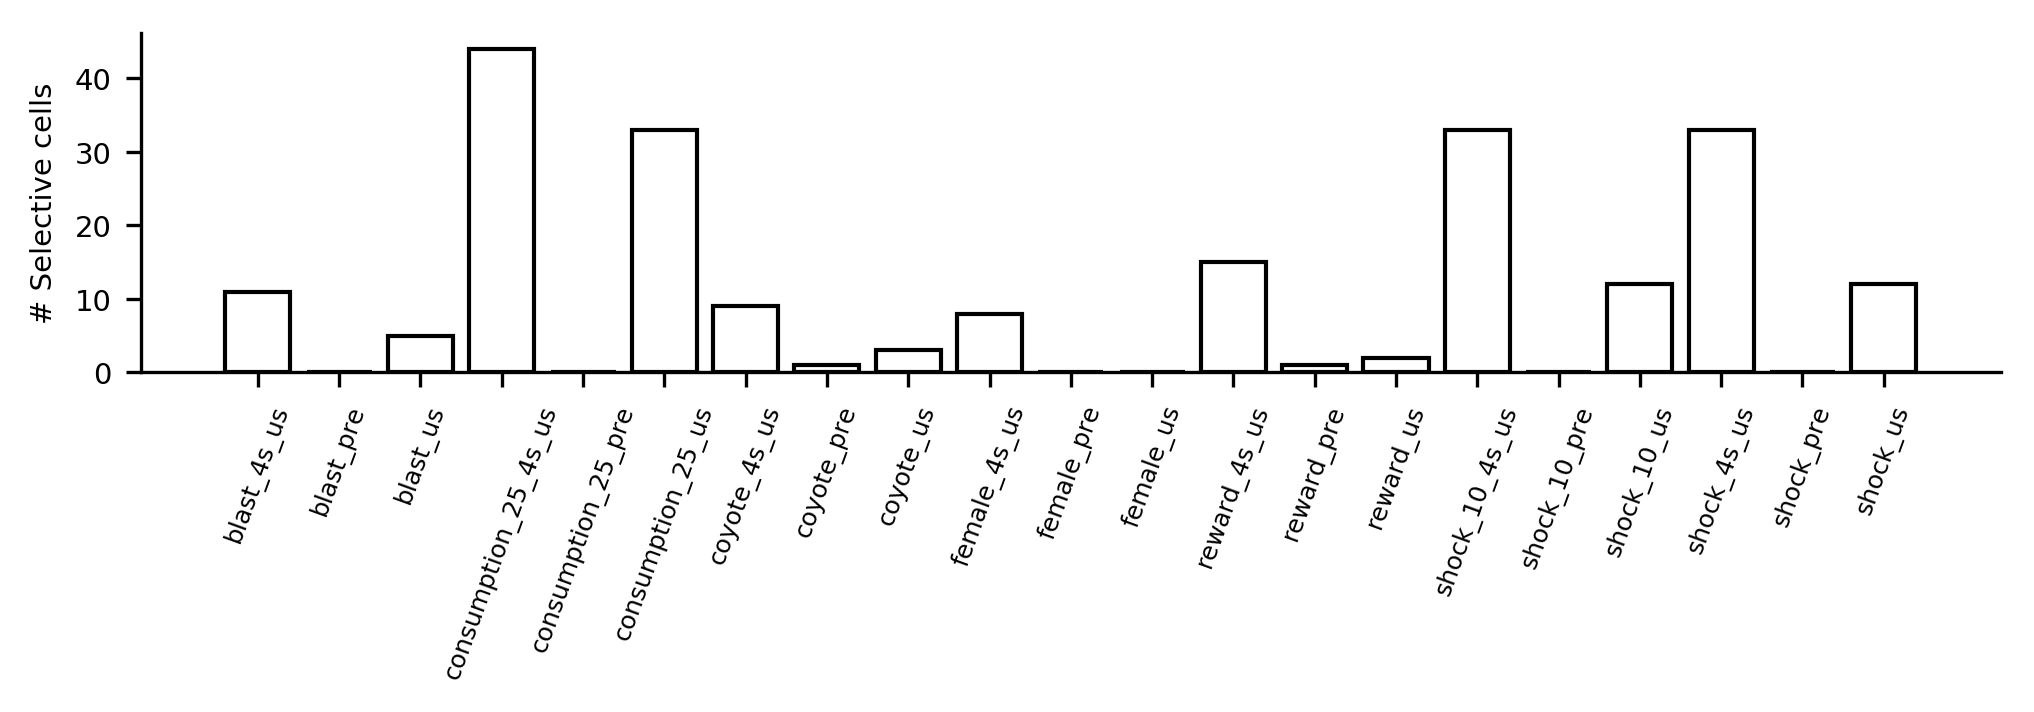

In [14]:
fig, ax = pl.subplots(1, 1, figsize=(8, 1.5))
values = [np.sum(ut.adjust_pvalues([s[1] for s in selectivity[t][:, 0]])<significance)
          for t in sorted(selectivity)]
pt.plot_bars(values, ax=ax)
ax.set_xticks(range(len(selectivity)))
ax.set_xticklabels(sorted(selectivity), rotation=70, fontsize=6)
pt.nicer_plot(ax)
ax.set_ylabel('# Selective cells')
# ax.set_ylim(0, 0.7)

(0, 0.6)

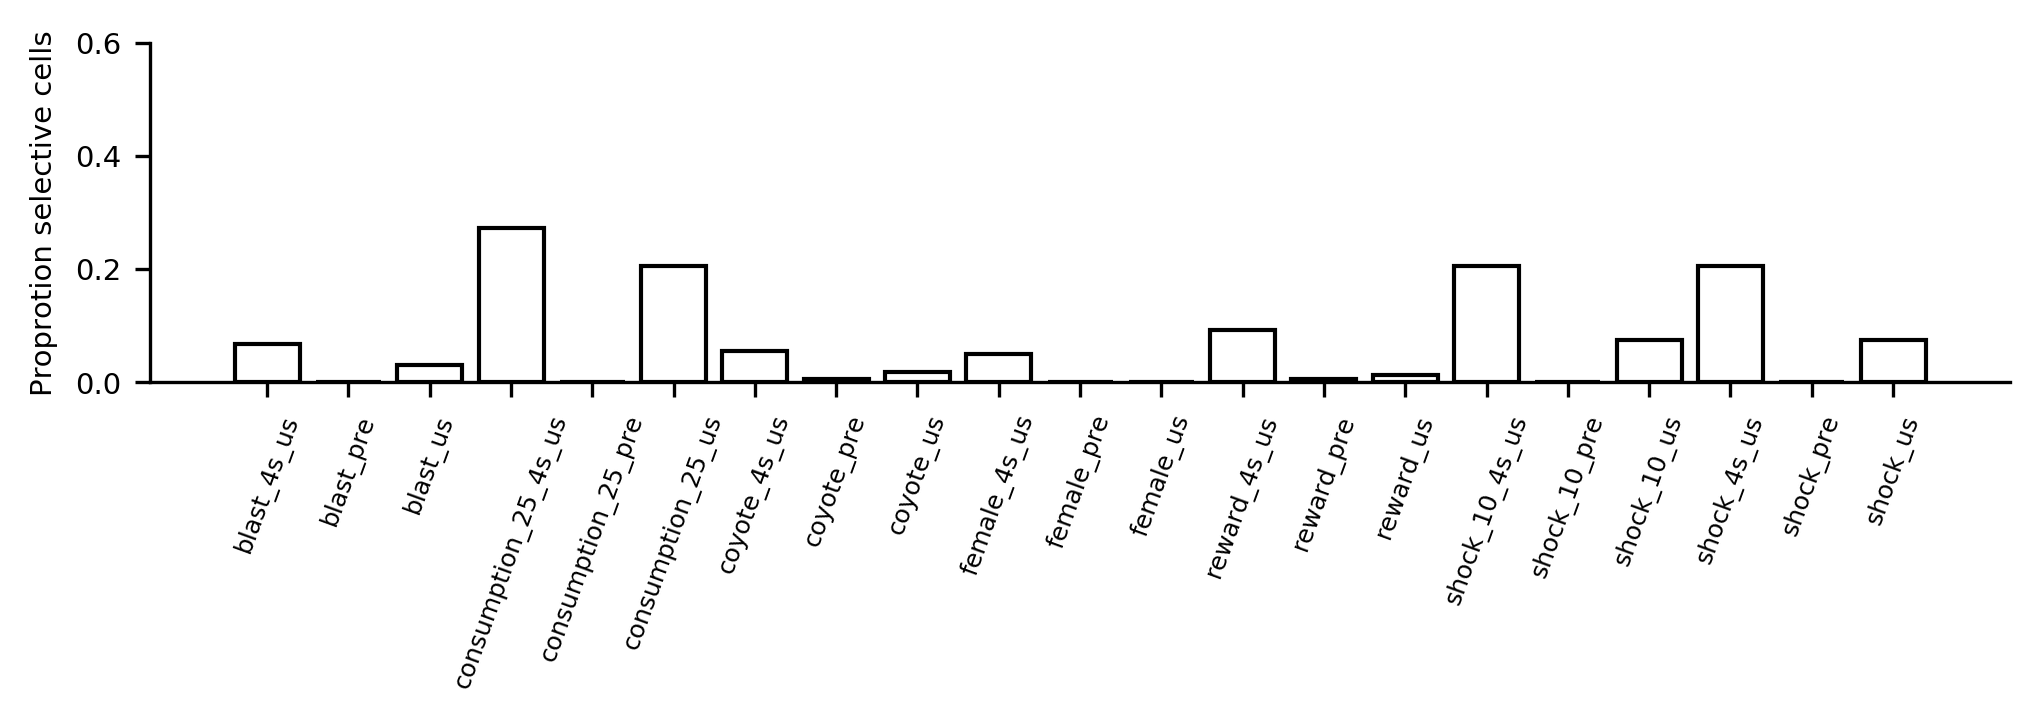

In [15]:
fig, ax = pl.subplots(1, 1, figsize=(8, 1.5))
values_float = [np.sum(ut.adjust_pvalues([s[1] for s in selectivity[t][:, 0]])<significance)
          for t in sorted(selectivity)]
[float(i) for i in values_float]
denominator = float(len(contours))
proportions = [v/denominator for v in values_float]
pt.plot_bars(proportions, ax=ax)
ax.set_xticks(range(len(selectivity)))
ax.set_xticklabels(sorted(selectivity), rotation=70, fontsize=6)
pt.nicer_plot(ax)
ax.set_ylabel('Proprotion selective cells')
ax.set_ylim(0, 0.6)

In [16]:
len(contours)

161

In [17]:
pvals_female_4s_us = ut.multipletests([s[0][-1] for s in selectivity['female_4s_us']], method='fdr_bh')[1]
dirs_female_4s_us = np.r_[[s[1] for s in selectivity['female_4s_us']]]
pvals_coyote_4s_us = ut.multipletests([s[0][-1] for s in selectivity['coyote_4s_us']], method='fdr_bh')[1]
dirs_coyote_4s_us = np.r_[[s[1] for s in selectivity['coyote_4s_us']]]
#pvals_sucrose_4s_us = ut.multipletests([s[0][-1] for s in selectivity['reward_4s_us']], method='fdr_bh')[1]
#dirs_sucrose_4s_us = np.r_[[s[1] for s in selectivity['reward_4s_us']]]
pvals_shock_10_4s_us = ut.multipletests([s[0][-1] for s in selectivity['shock_10_4s_us']], method='fdr_bh')[1]
dirs_shock_10_4s_us = np.r_[[s[1] for s in selectivity['shock_10_4s_us']]]
pvals_consumption_25_4s_us = ut.multipletests([s[0][-1] for s in selectivity['consumption_25_4s_us']], method='fdr_bh')[1]
dirs_consumption_25_4s_us = np.r_[[s[1] for s in selectivity['consumption_25_4s_us']]]

In [18]:
consumption_25_4s_us_up = (((pvals_consumption_25_4s_us<significance)*(dirs_consumption_25_4s_us>0))).sum()
shock_10_4s_us_up = (((pvals_shock_10_4s_us<significance)*(dirs_shock_10_4s_us>0))).sum()
consumption_25_4s_us_dn = (((pvals_consumption_25_4s_us<significance)*(dirs_consumption_25_4s_us<0))).sum()
shock_10_4s_us_dn = (((pvals_shock_10_4s_us<significance)*(dirs_shock_10_4s_us<0))).sum()
consumption_25_4s_us_up__shock_10_4s_us_up = (((pvals_consumption_25_4s_us<significance)*(dirs_consumption_25_4s_us>0))*((pvals_shock_10_4s_us<significance)*(dirs_shock_10_4s_us>0))).sum()
consumption_25_4s_us_dn__shock_10_4s_us_dn = (((pvals_consumption_25_4s_us<significance)*(dirs_consumption_25_4s_us<0))*((pvals_shock_10_4s_us<significance)*(dirs_shock_10_4s_us<0))).sum()
consumption_25_4s_us_up__shock_10_4s_us_dn = (((pvals_consumption_25_4s_us<significance)*(dirs_consumption_25_4s_us>0))*((pvals_shock_10_4s_us<significance)*(dirs_shock_10_4s_us<0))).sum()
consumption_25_4s_us_dn__shock_10_4s_us_up = (((pvals_consumption_25_4s_us<significance)*(dirs_consumption_25_4s_us<0))*((pvals_shock_10_4s_us<significance)*(dirs_shock_10_4s_us>0))).sum()

#odors
female_4s_us_up = (((pvals_female_4s_us<significance)*(dirs_female_4s_us>0))).sum()
coyote_4s_us_up = (((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us>0))).sum()
female_4s_us_dn = (((pvals_female_4s_us<significance)*(dirs_female_4s_us<0))).sum()
coyote_4s_us_dn = (((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us<0))).sum()
female_4s_us_up__coyote_4s_us_up = (((pvals_female_4s_us<significance)*(dirs_female_4s_us>0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us>0))).sum()
female_4s_us_dn__coyote_4s_us_dn = (((pvals_female_4s_us<significance)*(dirs_female_4s_us<0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us<0))).sum()
female_4s_us_up__coyote_4s_us_dn = (((pvals_female_4s_us<significance)*(dirs_female_4s_us>0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us<0))).sum()
female_4s_us_dn__coyote_4s_us_up = (((pvals_female_4s_us<significance)*(dirs_female_4s_us<0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us>0))).sum()

In [19]:
#blasts
pvals_blast_4s_us = ut.multipletests([s[0][-1] for s in selectivity['blast_4s_us']], method='fdr_bh')[1]
dirs_blast_4s_us = np.r_[[s[1] for s in selectivity['blast_4s_us']]]

blast_4s_us_up = (((pvals_blast_4s_us<significance)*(dirs_blast_4s_us>0))).sum()
blast_4s_us_dn = (((pvals_blast_4s_us<significance)*(dirs_blast_4s_us<0))).sum()

In [20]:
print "There are", consumption_25_4s_us_up, "cells that increase activity to consumption_25."
print "There are", shock_10_4s_us_up, "cells that increase activity to shock_10."
print "There are", consumption_25_4s_us_dn, "cells that decrease activity to consumption_25."
print "There are", shock_10_4s_us_dn, "cells that decrease activity to shock_10."
print "There are", consumption_25_4s_us_up__shock_10_4s_us_up, "cells that increase activity to both consumption_25 and shock_10."
print "There are", consumption_25_4s_us_dn__shock_10_4s_us_dn, "cells that decrase activity to both consumption_25 and shock_10."
print "There are", consumption_25_4s_us_up__shock_10_4s_us_dn, "cells that increase activity to consumption_25 and decrease to shock_10."
print "There are", consumption_25_4s_us_dn__shock_10_4s_us_up, "cells that decrase activity to consumption_25 and increase shock_10."

There are 40 cells that increase activity to consumption_25.
There are 28 cells that increase activity to shock_10.
There are 4 cells that decrease activity to consumption_25.
There are 5 cells that decrease activity to shock_10.
There are 8 cells that increase activity to both consumption_25 and shock_10.
There are 1 cells that decrase activity to both consumption_25 and shock_10.
There are 1 cells that increase activity to consumption_25 and decrease to shock_10.
There are 0 cells that decrase activity to consumption_25 and increase shock_10.


In [21]:
print "There are", female_4s_us_up, "cells that increase activity to female."
print "There are", coyote_4s_us_up, "cells that increase activity to coyote."
print "There are", female_4s_us_dn, "cells that decrease activity to female."
print "There are", coyote_4s_us_dn, "cells that decrease activity to coyote."
print "There are", female_4s_us_up__coyote_4s_us_up, "cells that increase activity to both female and coyote."
print "There are", female_4s_us_dn__coyote_4s_us_dn, "cells that decrase activity to both female and coyote."
print "There are", female_4s_us_up__coyote_4s_us_dn, "cells that increase activity to female and decrease to coyote."
print "There are", female_4s_us_dn__coyote_4s_us_up, "cells that decrase activity to female and increase coyote."

There are 7 cells that increase activity to female.
There are 5 cells that increase activity to coyote.
There are 1 cells that decrease activity to female.
There are 4 cells that decrease activity to coyote.
There are 2 cells that increase activity to both female and coyote.
There are 0 cells that decrase activity to both female and coyote.
There are 0 cells that increase activity to female and decrease to coyote.
There are 0 cells that decrase activity to female and increase coyote.


In [22]:
tuned_cells = {}
for k, v in selectivity.iteritems():
    corrected_ps = ut.adjust_pvalues([s[1] for s in selectivity[k][:, 0]])
    tuned_cells[k] = [np.where((corrected_ps<significance)*([s>0 for s in v[:, 1]]))[0],
                      np.where((corrected_ps<significance)*([s<0 for s in v[:, 1]]))[0],]

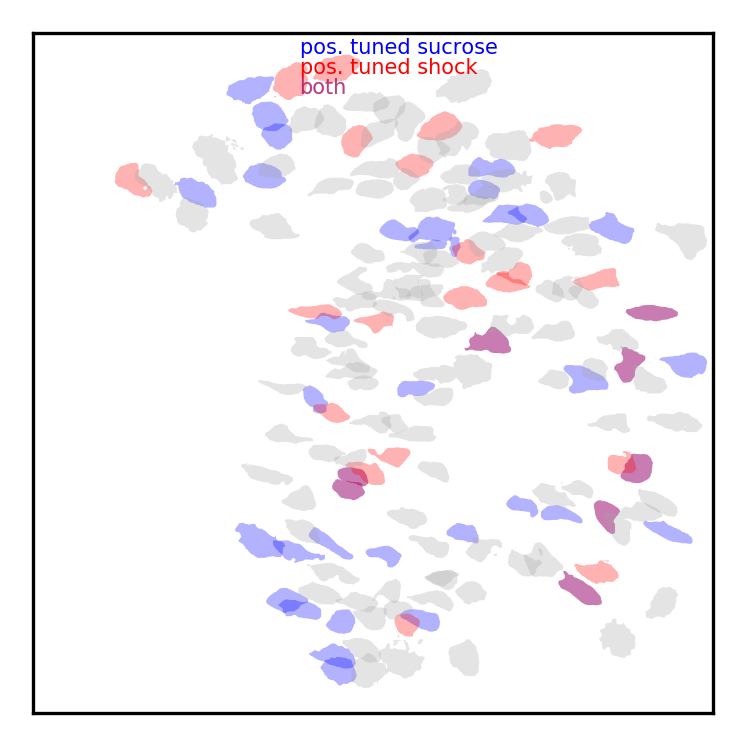

In [23]:
list_of_cells = [tuned_cells['consumption_25_4s_us'][0], tuned_cells['shock_10_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned sucrose', color='b', fontsize=5)
ax.text(200, 30, 'pos. tuned shock', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

../../../../../code/plots.py:164: RuntimeWarning: invalid value encountered in greater
  mask=np.where(abs(np.diff(contours[neuron][dim]))>10)


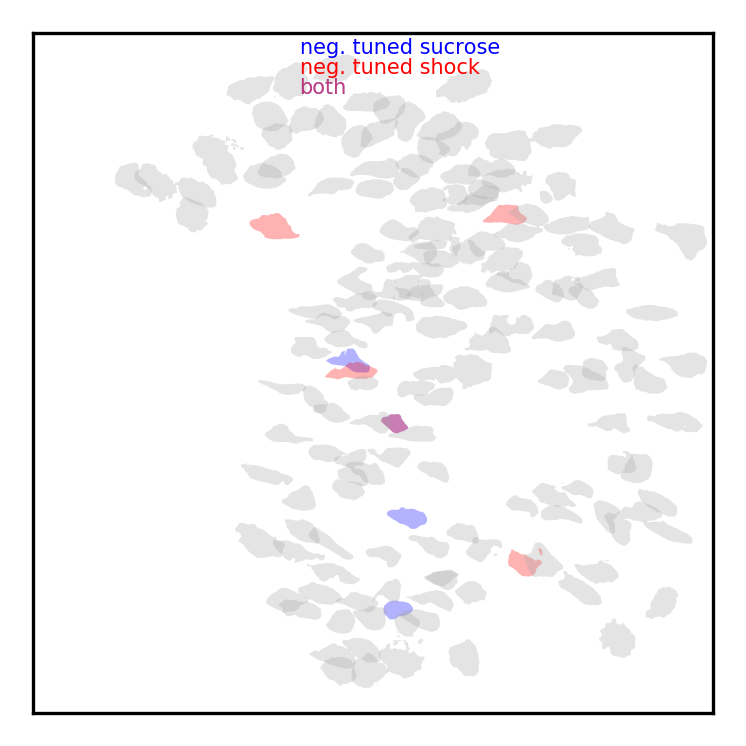

In [24]:
list_of_cells = [tuned_cells['consumption_25_4s_us'][1], tuned_cells['shock_10_4s_us'][1]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'neg. tuned sucrose', color='b', fontsize=5)
ax.text(200, 30, 'neg. tuned shock', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

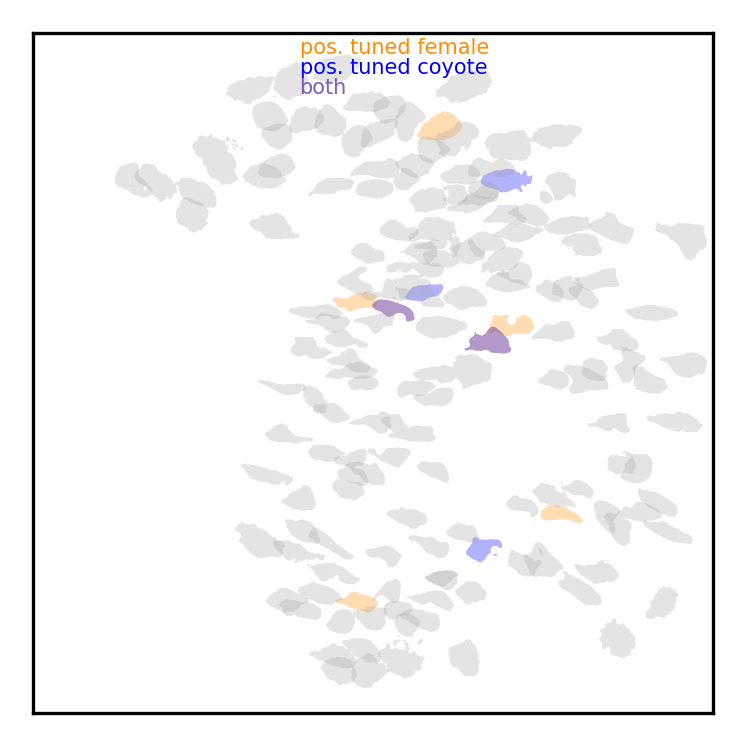

In [25]:
list_of_cells = [tuned_cells['female_4s_us'][0], tuned_cells['coyote_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['darkorange', 'b', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned female', color='darkorange', fontsize=5)
ax.text(200, 30, 'pos. tuned coyote', color='b', fontsize=5)
ax.text(200, 45, 'both', color='darkorange', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)

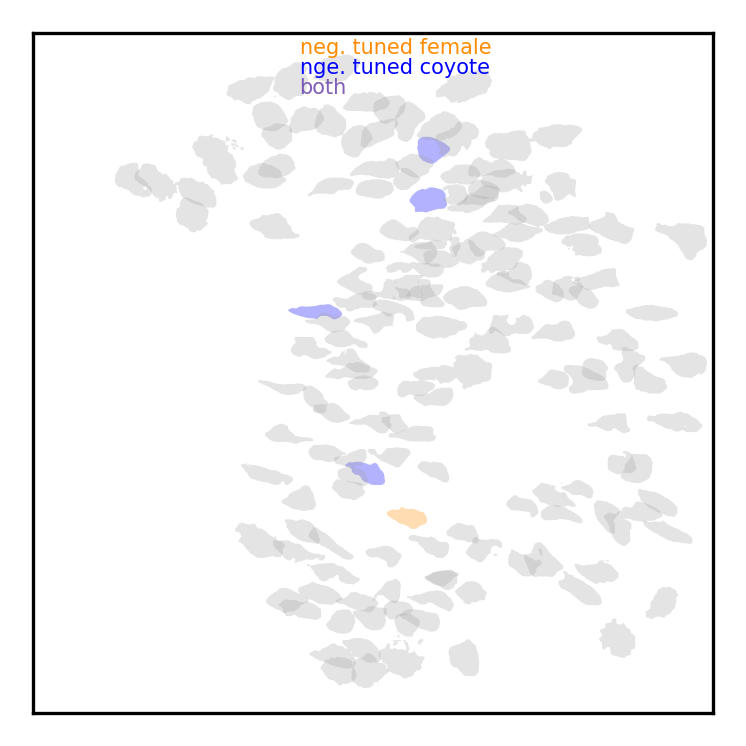

In [26]:
list_of_cells = [tuned_cells['female_4s_us'][1], tuned_cells['coyote_4s_us'][1]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['darkorange', 'b', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'neg. tuned female', color='darkorange', fontsize=5)
ax.text(200, 30, 'nge. tuned coyote', color='b', fontsize=5)
ax.text(200, 45, 'both', color='darkorange', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)

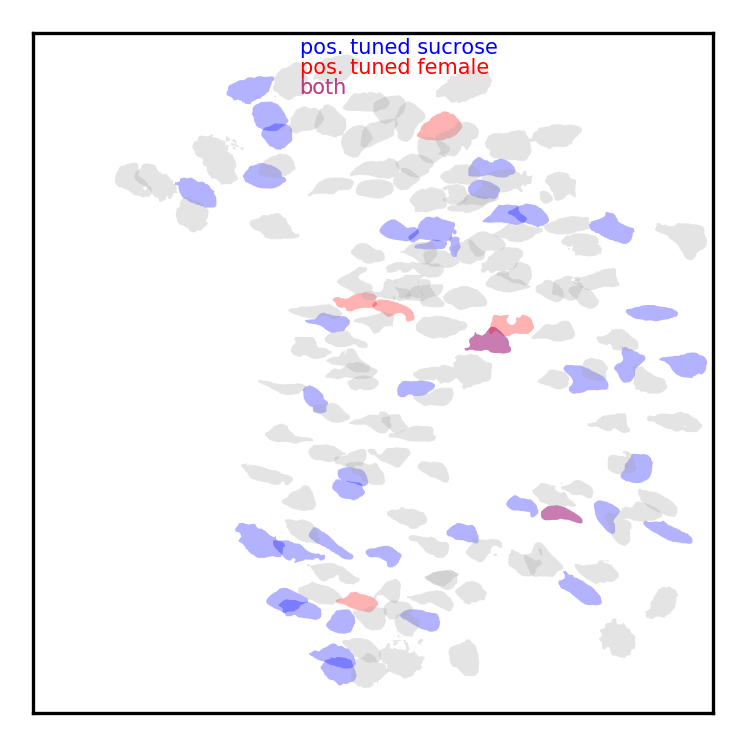

In [27]:
list_of_cells = [tuned_cells['consumption_25_4s_us'][0], tuned_cells['female_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned sucrose', color='b', fontsize=5)
ax.text(200, 30, 'pos. tuned female', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

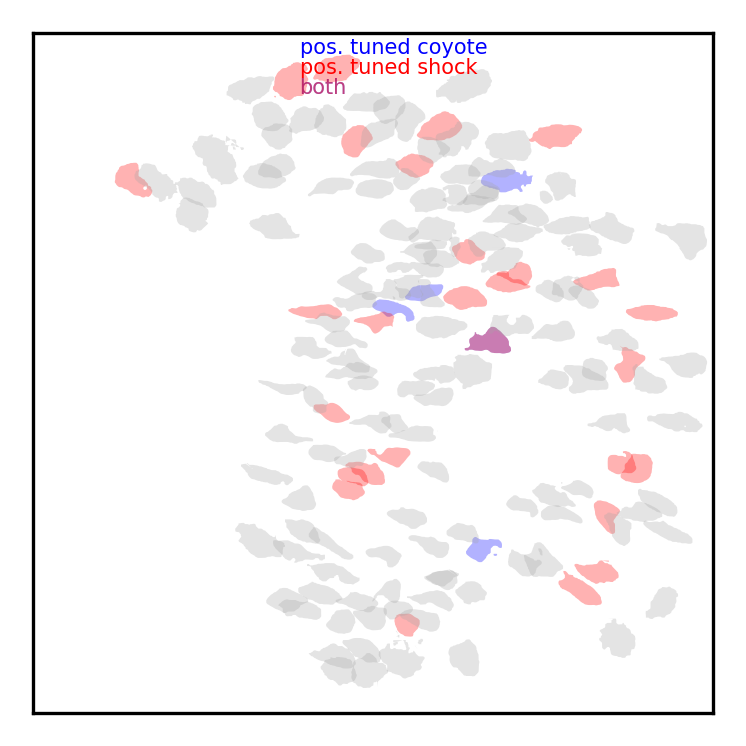

In [28]:
list_of_cells = [tuned_cells['coyote_4s_us'][0], tuned_cells['shock_10_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned coyote', color='b', fontsize=5)
ax.text(200, 30, 'pos. tuned shock', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

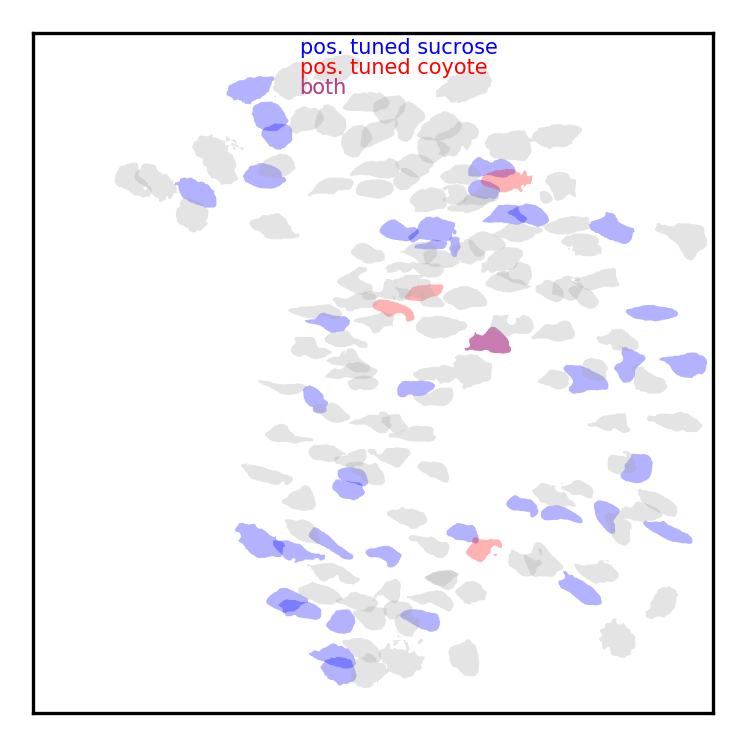

In [29]:
list_of_cells = [tuned_cells['consumption_25_4s_us'][0], tuned_cells['coyote_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned sucrose', color='b', fontsize=5)
ax.text(200, 30, 'pos. tuned coyote', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

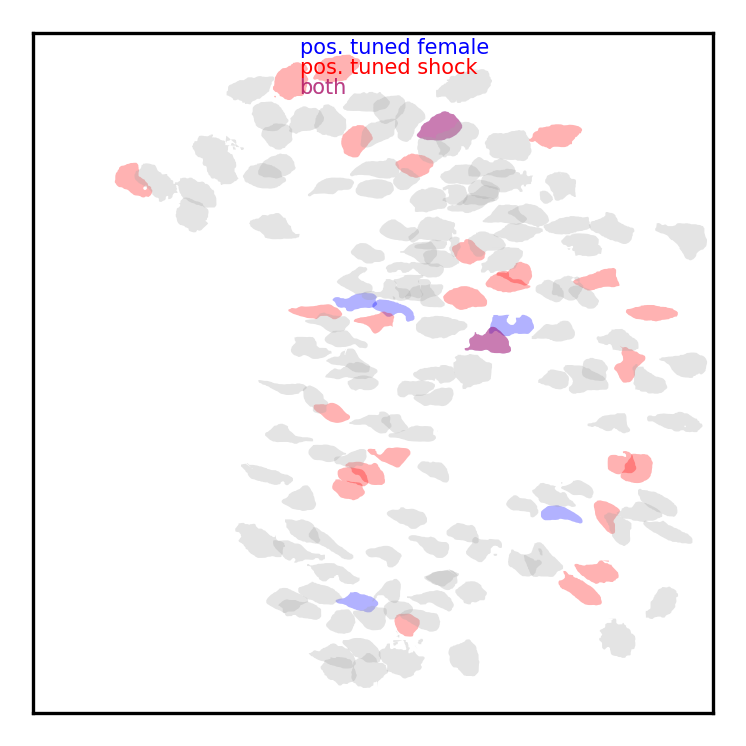

In [30]:
list_of_cells = [tuned_cells['female_4s_us'][0], tuned_cells['shock_10_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned female', color='b', fontsize=5)
ax.text(200, 30, 'pos. tuned shock', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

In [31]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
